In [1]:
from data.load_data import load_cache_behavior_neuropixel, get_trial_df
import numpy as np
import matplotlib.pyplot as plt # used for plotting data
%matplotlib inline
from numpy import linalg as LA
from numpy.linalg import matrix_rank
from scipy.stats import pearsonr
import my_functions_notebook as mf
import my_functions_for_plots as mf_plots
from scipy.stats import ks_2samp

In [2]:
#In case we need to reload  functions

#import importlib
#importlib.reload(mf)
#importlib.reload(mf_plots)

In [3]:
#loading cache and selecting the session
cache = load_cache_behavior_neuropixel()

#session_number = 27
session_number = 31
#sessions_to_iterate = cache.get_ecephys_session_table().index.values[:number_of_sessions]
sessions_to_iterate = [1053925378, 1081090969, 1064415305, 1108334384, 1115356973]

#3rd is the best, 4th is bad

In [4]:
#Brain region and quality matrix
my_area = 'VISp'
amplitude_cutoff_maximum = 0.1
presence_ratio_minimum = 0.9
isi_violations_maximum = 0.5

In [5]:
#get trial_df
#session_id = cache.get_ecephys_session_table().index.values[session_number]
session_id = sessions_to_iterate[2]

session = cache.get_ecephys_session(session_id)
trial_df = get_trial_df(session)

/root/capsule/code/data/load_data.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pres_df['image_int'] = pres_df.image_name.apply( lambda img: image_to_int[img] )


In [6]:
#select go-hit trials or go-miss trials
trials = session.trials
trial_df['stim_id'] = trial_df.index.values

#merge with trials features
m_df = trial_df.merge(right=trials, on='trials_id')
m_df.index = m_df.stim_id
m_df = m_df.sort_index()

#build the vector to get the type of trial per each trial

idx_hit_mode = np.zeros(trial_df.shape[0])
idx_miss_mode = np.zeros(trial_df.shape[0])

for i in range(0,trial_df.shape[0]):
    idx_hit_mode[i] = m_df.iloc[i].hit
    idx_miss_mode[i] = m_df.iloc[i].miss
    

In [7]:
#get the spike data

VISp_units = mf.get_spike_data(cache, session, my_area, amplitude_cutoff_maximum, presence_ratio_minimum, isi_violations_maximum)

#get firing rates (and their normalized versions, where each firing rate is normalized with respect to its maximum)
    
firing_rates, norm_firing_rates, idx_image_int, idx_active, idx_image_order = mf.get_norm_firing_rates_per_stim_ID(VISp_units, session, trial_df)

In [8]:
#select only the same stimuli with their presentation order

#ACTIVE - hit trials only

mean_firing_rates_per_image_int_ACTIVE, mean_firing_rates_per_image_int_and_order_ACTIVE = mf.grouping_stimuli(VISp_units, firing_rates, trial_df, idx_active, idx_image_int, idx_image_order, True, True, False, idx_hit_mode, idx_miss_mode)

#PASSIVE - hit trials only

mean_firing_rates_per_image_int_PASSIVE, mean_firing_rates_per_image_int_and_order_PASSIVE = mf.grouping_stimuli(VISp_units, firing_rates, trial_df, idx_active, idx_image_int, idx_image_order, False, True, False, idx_hit_mode, idx_miss_mode)
     

In [9]:
#build the signal axes

images = np.unique(trial_df.image_int.values)
num_images = len(images)
num_units = len(VISp_units.index.values)
num_pairs = int(num_images*(num_images-1)/2)
signal_axes_ACTIVE = np.zeros((num_units, num_pairs))
signal_axes_PASSIVE = np.zeros((num_units, num_pairs))

idx_pair = 0
for i in range(0,num_images):
    for j in range(i+1,num_images):
        
        signal_axes_ACTIVE[:,idx_pair] = mean_firing_rates_per_image_int_ACTIVE[:,i] - mean_firing_rates_per_image_int_ACTIVE[:,j]
        signal_axes_PASSIVE[:,idx_pair] = mean_firing_rates_per_image_int_PASSIVE[:,i] - mean_firing_rates_per_image_int_PASSIVE[:,j]

        idx_pair = idx_pair +1


In [10]:
#extract eigenvectors from noise correlations

#first, compute NOISE correlations

#ACTIVE - hit trials only

noise_correlations_per_image_ACTIVE, noise_correlations_with_image_order_ACTIVE, mean_noise_correlations_ACTIVE, mean_noise_correlations_per_image_order_ACTIVE = mf.get_noise_correlations(trial_df, VISp_units, firing_rates, idx_image_int, idx_active, idx_image_order, True, True, False, idx_hit_mode, idx_miss_mode)

#PASSIVE - hit trials only

noise_correlations_per_image_PASSIVE, noise_correlations_with_image_order_PASSIVE, mean_noise_correlations_PASSIVE, mean_noise_correlations_per_image_order_PASSIVE = mf.get_noise_correlations(trial_df, VISp_units, firing_rates, idx_image_int, idx_active, idx_image_order, False, True, False, idx_hit_mode, idx_miss_mode)

#Eigenvectors per each image

eigenvectors_matrices_NC_A = np.zeros((num_units,num_units,num_images))
eigenvectors_matrices_NC_P = np.zeros((num_units,num_units,num_images))

eigenvalues_matrix_NC_A = np.zeros((num_units,num_images))
eigenvalues_matrix_NC_P = np.zeros((num_units,num_images))

for i in range(0,num_images):

    eigenvalues_matrix_NC_A_tmp, eigenvectors_matrices_NC_A_tmp = LA.eig(np.nan_to_num(noise_correlations_per_image_ACTIVE[:,:,i], nan = 0))
    eigenvalues_matrix_NC_A[:,i] = eigenvalues_matrix_NC_A_tmp
    eigenvectors_matrices_NC_A[:,:,i] = eigenvectors_matrices_NC_A_tmp
    
    eigenvalues_matrix_NC_P_tmp, eigenvectors_matrices_NC_P_tmp = LA.eig(np.nan_to_num(noise_correlations_per_image_PASSIVE[:,:,i], nan = 0))
    eigenvalues_matrix_NC_P[:,i] = eigenvalues_matrix_NC_P_tmp
    eigenvectors_matrices_NC_P[:,:,i] = eigenvectors_matrices_NC_P_tmp
    
#eigenvectors and eigenvalues of mean noise correlations matrix
eigenvectors_mean_matrix_NC_A = np.zeros((num_units,num_units))
eigenvalues_mean_matrix_NC_A = np.zeros(num_units)

eigenvectors_mean_matrix_NC_P = np.zeros((num_units,num_units))
eigenvalues_mean_matrix_NC_P = np.zeros(num_units)

eigenvalues_mean_matrix_NC_A, eigenvectors_mean_matrix_NC_A = LA.eig(np.nan_to_num(mean_noise_correlations_ACTIVE, nan = 0))
eigenvalues_mean_matrix_NC_P, eigenvectors_mean_matrix_NC_P = LA.eig(np.nan_to_num(mean_noise_correlations_PASSIVE, nan = 0))


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/root/capsule/local_notebooks/my_functions_notebook.py:105: RuntimeWarning: Mean of empty slice
  mean_noise_correlations_per_image_order = np.nanmean(noise_correlations_with_image_order,axis=2)


In [11]:
#angles between signal axes and noise correlations 

all_angles_ACTIVE = np.zeros(num_pairs*num_images)
all_angles_PASSIVE = np.zeros(num_pairs*num_images)

idx_angle = 0
for i in range(0,num_pairs):
    for j in range(0,num_images):
        all_angles_ACTIVE[idx_angle] = mf.angle_between_vectors(signal_axes_ACTIVE[:,i], eigenvectors_matrices_NC_A[:,0,j])
        all_angles_PASSIVE[idx_angle] = mf.angle_between_vectors(signal_axes_PASSIVE[:,i], eigenvectors_matrices_NC_P[:,0,j])
       
        idx_angle = idx_angle + 1
    

KS Statistic: 0.1607
KS Test p-value (permutations): 0.0030
Significance Level (alpha): 0.0500
The two datasets are statistically different.


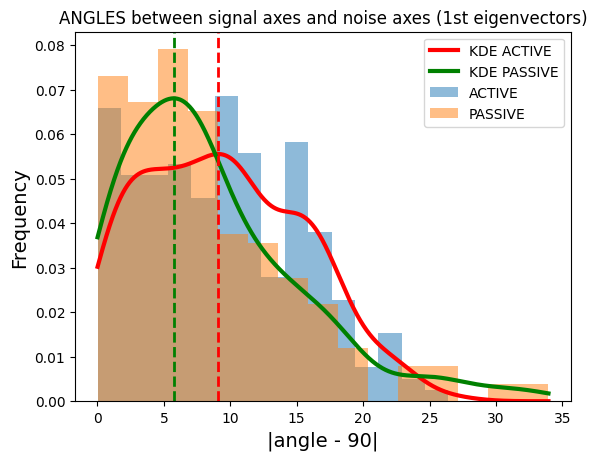

In [12]:
nbins = 15
mf_plots.plot_and_test_histograms(np.abs(all_angles_ACTIVE-90), np.abs(all_angles_PASSIVE-90), nbins, 1000, 0.05, '|angle - 90|', 'ANGLES between signal axes and noise axes (1st eigenvectors)', True)


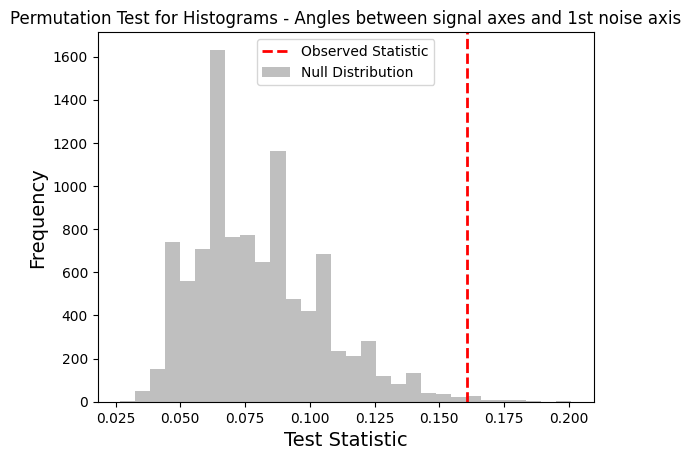

p-value: 0.0060


(0.0059994000599940004, True)

In [13]:
#statistical test
mf_plots.permutation_test_histograms(np.abs(all_angles_ACTIVE-90), np.abs(all_angles_PASSIVE-90), 10000, 0.05, title = 'Permutation Test for Histograms - Angles between signal axes and 1st noise axis')

In [14]:
#let's do the same for the other eigenvectors

#angles between signal axes and noise correlations (2nd eigenv)

all_angles_ACTIVE_2 = np.zeros(num_pairs)
all_angles_PASSIVE_2 = np.zeros(num_pairs)

idx_angle = 0
for i in range(0,num_pairs):
        all_angles_ACTIVE_2[idx_angle] = mf.angle_between_vectors(signal_axes_ACTIVE[:,i], eigenvectors_mean_matrix_NC_A[:,1])
        all_angles_PASSIVE_2[idx_angle] = mf.angle_between_vectors(signal_axes_PASSIVE[:,i], eigenvectors_mean_matrix_NC_P[:,1])
       
        idx_angle = idx_angle + 1
    

KS Statistic: 0.2143
KS Test p-value (permutations): 0.5365
Significance Level (alpha): 0.0500
There is no significant difference between the two datasets.


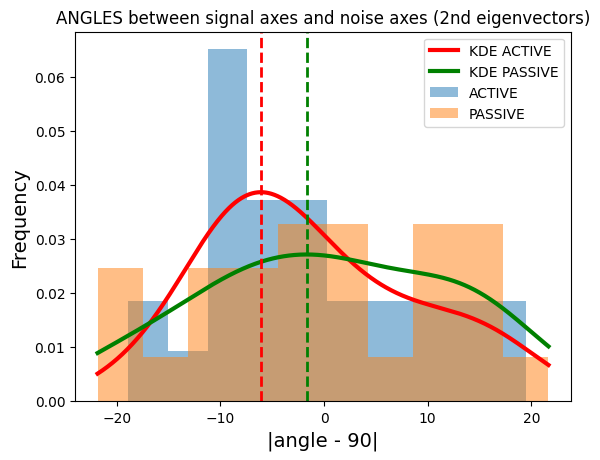

In [15]:
nbins_2 = 10
mf_plots.plot_and_test_histograms((all_angles_ACTIVE_2-90), (all_angles_PASSIVE_2-90), nbins_2, 1000, 0.05, '|angle - 90|', 'ANGLES between signal axes and noise axes (2nd eigenvectors)', True)


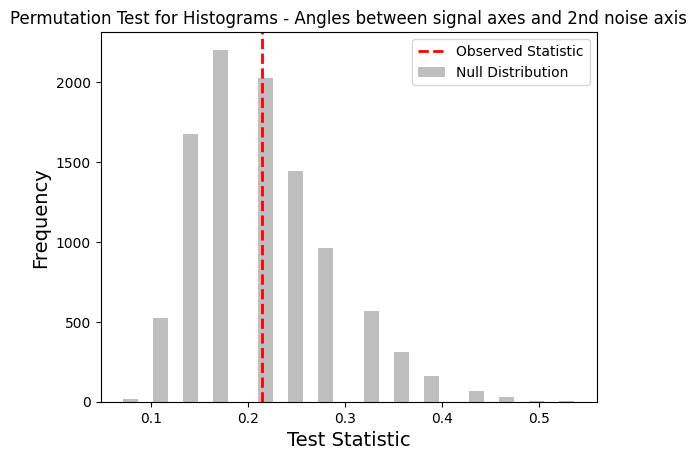

p-value: 0.5580


(0.5580441955804419, False)

In [16]:
#statistical test
mf_plots.permutation_test_histograms((all_angles_ACTIVE_2-90), (all_angles_PASSIVE_2-90), 10000, 0.05, title = 'Permutation Test for Histograms - Angles between signal axes and 2nd noise axis')

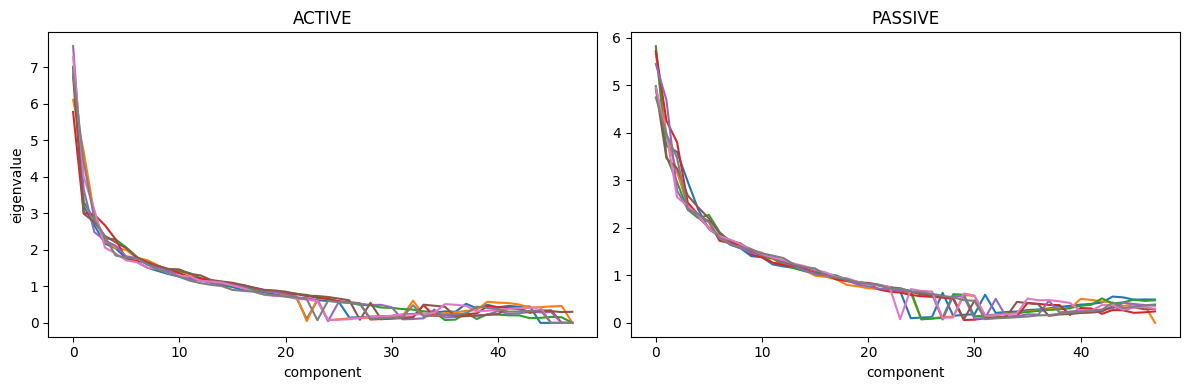

In [17]:
#study eigenvalues

# Create a figure with two subplots side by side
fig_eigen, ax_eigen = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize as needed

# Plot the first data on the first subplot
for i in range(0,num_images):
    
    ax_eigen[0].plot(eigenvalues_matrix_NC_A[:,i])
    
ax_eigen[0].set_title('ACTIVE')
ax_eigen[0].set_xlabel('component')
ax_eigen[0].set_ylabel('eigenvalue')

# Plot the second data on the second subplot
for i in range(0,num_images):
    
    ax_eigen[1].plot(eigenvalues_matrix_NC_P[:,i])
    

ax_eigen[1].set_title('PASSIVE')
ax_eigen[1].set_xlabel('component')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


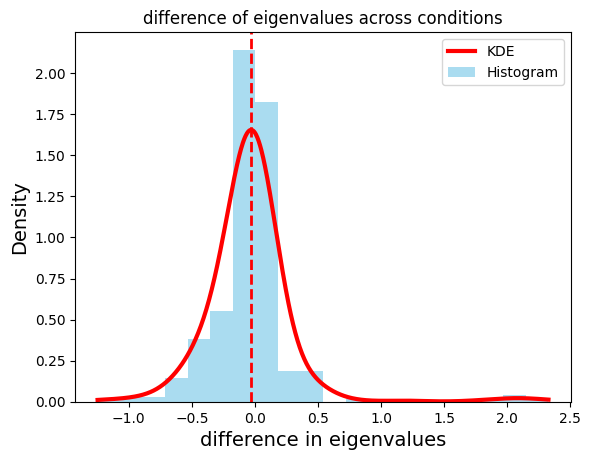

In [18]:
#check differences between eigenvalues across conditions (ACTIVE - PASSIVE)

differences_eigen = np.zeros(int(num_images*num_units))

idx_diff = 0
for i in range(0,num_images):
    differences_eigen[i*num_units:(i+1)*num_units] = eigenvalues_matrix_NC_A[:,i] - eigenvalues_matrix_NC_P[:,i]
    
    
mf_plots.fit_and_plot_histogram(differences_eigen, xlabel='difference in eigenvalues', title='difference of eigenvalues across conditions', num_bins=20)

In [19]:
eigenvalues_matrix_NC_A.shape, num_units, differences_eigen.shape, (eigenvalues_matrix_NC_A[:,i] - eigenvalues_matrix_NC_P[:,i]).shape, np.arange(0,(0+1)*num_units)

((48, 8),
 48,
 (384,),
 (48,),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))

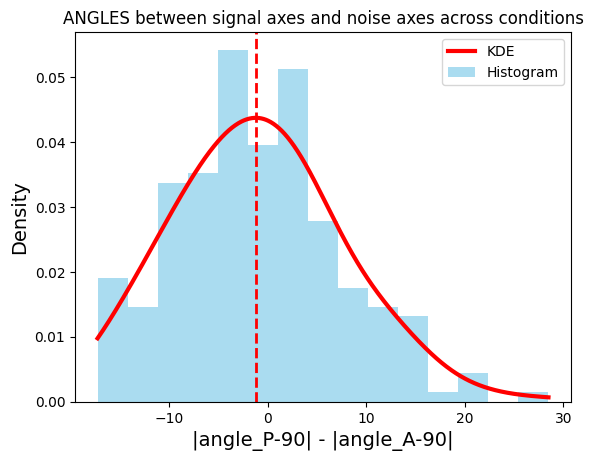

In [20]:
#pair differences between angles
pair_differences = (np.abs(all_angles_PASSIVE-90) - np.abs(all_angles_ACTIVE - 90))
mf_plots.fit_and_plot_histogram(pair_differences, xlabel='|angle_P-90| - |angle_A-90|', title='ANGLES between signal axes and noise axes across conditions', num_bins=15)

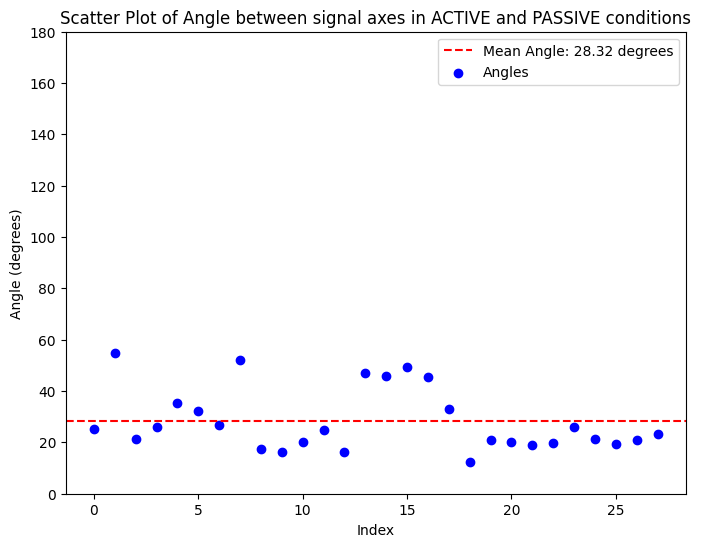

In [21]:
#ROTATION of SIGNAL AXES

angles_signal_axes_ACT_PASS = mf.compute_angles_between_matrices_row_vectors(signal_axes_ACTIVE.T, signal_axes_PASSIVE.T)

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
index = np.arange(0,len(angles_signal_axes_ACT_PASS))
plt.scatter(index, angles_signal_axes_ACT_PASS, c='blue', marker='o', label='Angles')

mean_angle = np.mean(angles_signal_axes_ACT_PASS)
# Add a dashed line for the mean
plt.axhline(mean_angle, color='red', linestyle='--', label=f'Mean Angle: {mean_angle:.2f} degrees')

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.title('Scatter Plot of Angle between signal axes in ACTIVE and PASSIVE conditions')
#plt.grid(True)
plt.legend()
plt.ylim(0, 180)
# Show the plot
plt.show()

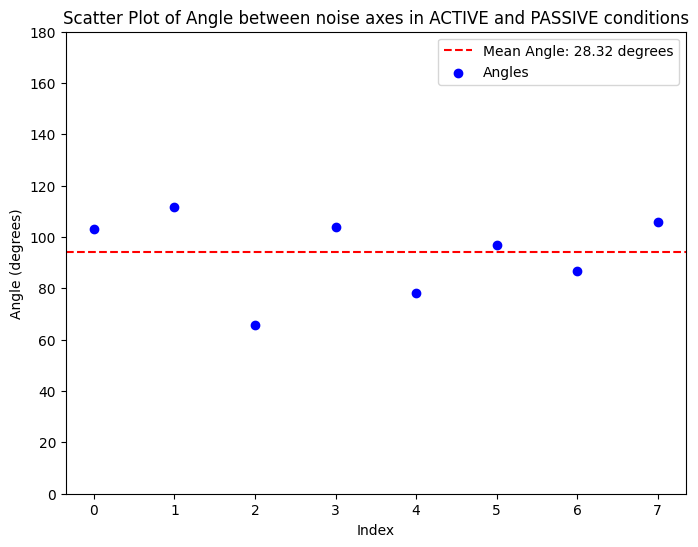

In [22]:
#ROTATION of NOISE AXES

angles_noise_axes_ACT_PASS_1 = mf.compute_angles_between_matrices_row_vectors(eigenvectors_matrices_NC_A[:,0,:].T, eigenvectors_matrices_NC_P[:,0,:].T)
angles_noise_axes_ACT_PASS_2 = mf.compute_angles_between_matrices_row_vectors(eigenvectors_matrices_NC_A[:,1,:].T, eigenvectors_matrices_NC_P[:,1,:].T)
angles_noise_axes_ACT_PASS_3 = mf.compute_angles_between_matrices_row_vectors(eigenvectors_matrices_NC_A[:,2,:].T, eigenvectors_matrices_NC_P[:,2,:].T)
angles_noise_axes_ACT_PASS_4 = mf.compute_angles_between_matrices_row_vectors(eigenvectors_matrices_NC_A[:,2,:].T, eigenvectors_matrices_NC_P[:,3,:].T)
angles_noise_axes_ACT_PASS_5 = mf.compute_angles_between_matrices_row_vectors(eigenvectors_matrices_NC_A[:,2,:].T, eigenvectors_matrices_NC_P[:,4,:].T)


# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
index = np.arange(0,len(angles_noise_axes_ACT_PASS_1))
plt.scatter(index, angles_noise_axes_ACT_PASS_1, c='blue', marker='o', label='Angles')

mean_angle_noise = np.mean(angles_noise_axes_ACT_PASS_1)
# Add a dashed line for the mean
plt.axhline(mean_angle_noise, color='red', linestyle='--', label=f'Mean Angle: {mean_angle:.2f} degrees')

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.title('Scatter Plot of Angle between noise axes in ACTIVE and PASSIVE conditions')
#plt.grid(True)
plt.legend()
plt.ylim(0, 180)
# Show the plot
plt.show()

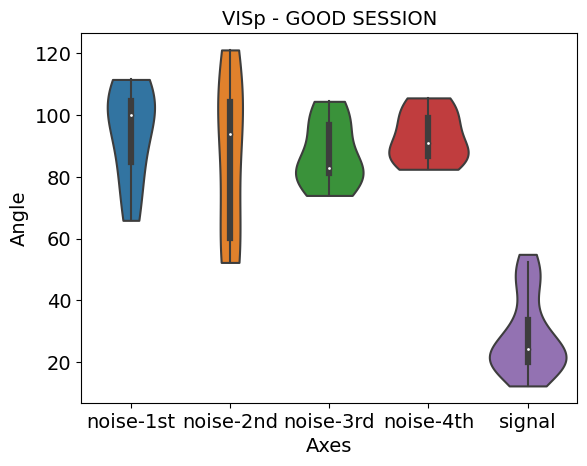

In [36]:
data = list()
for el in angles_noise_axes_ACT_PASS_1:
    data.append( dict(variable="noise-1st", angle=el) )

for el in angles_noise_axes_ACT_PASS_2:
    data.append( dict(variable="noise-2nd", angle=el) )

for el in angles_noise_axes_ACT_PASS_3:
    data.append( dict(variable="noise-3rd", angle=el) )

for el in angles_noise_axes_ACT_PASS_4:
    data.append( dict(variable="noise-4th", angle=el) )

#for el in angles_noise_axes_ACT_PASS_5:
 #   data.append( dict(variable="noise - 5", angle=el) )

for el in angles_signal_axes_ACT_PASS:
    data.append( dict(variable="signal", angle=el) )
    
data_only_first = list()
for el in angles_noise_axes_ACT_PASS_1:
    data_only_first.append( dict(variable="noise - 1", angle=el) )

for el in angles_signal_axes_ACT_PASS:
    data_only_first.append( dict(variable="signal", angle=el) )
    
import pandas as pd
import seaborn as sns

df = pd.DataFrame( data )
df_only_first = pd.DataFrame( data_only_first )

sns.violinplot(data=df, x="variable", y="angle", cut=0)

# Set x-label, y-label, and font size
plt.xlabel('Axes', fontsize=14)
plt.ylabel('Angle', fontsize=14)
plt.xticks(fontsize=14)  # Adjust the x-axis tick label font size
plt.yticks(fontsize=14)  # Adjust the y-axis tick label font size
plt.title('VISp - GOOD SESSION', fontsize=14)
#plt.figure(figsize=(25, 8))  # Adjust the figure size as needed
# Save the plot to a file (e.g., PNG)
plt.savefig('violin_VISp_GOOD_session.png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

<AxesSubplot:xlabel='variable', ylabel='angle'>

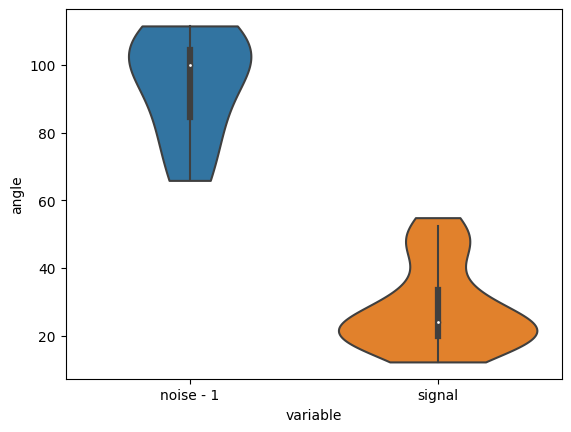

In [24]:
sns.violinplot(data=df_only_first, x="variable", y="angle", cut=0)

In [25]:
angles_PCA_ACT_PASS_2 = compute_angles_between_matrices_row_columns(signal_axes_ACTIVE.T, signal_axes_PASSIVE.T)
plt.plot(angles_PCA_ACT_PASS_2)
#plt.hist(angles_PCA_ACT_PASS_2, bins=6)

NameError: name 'compute_angles_between_matrices_row_columns' is not defined

In [ ]:
#ADDITIONAL - PCA

In [ ]:
from sklearn.decomposition import PCA

# Generate random N-dimensional data for 28 vectors
np.random.seed(0)  # For reproducibility
N = signal_axes_ACTIVE.shape[0]  # The dimensionality of each vector
num_vectors = signal_axes_ACTIVE.shape[1]
data = signal_axes_ACTIVE.T

# Perform PCA
pca = PCA(n_components=28)
data_pca = pca.fit_transform(data)

# Perform PCA over PASSIVE
pca_P = PCA(n_components=28)
data_pca_P = pca_P.fit_transform(signal_axes_PASSIVE.T)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.plot(np.cumsum(pca_P.explained_variance_)/np.sum(pca_P.explained_variance_))